In [1]:
import sys
sys.path.append('../../src')
%load_ext autoreload
%autoreload 2
import numpy as np
import tqdm
from collections import defaultdict

In [2]:
import pandas as pd

In [3]:
from dfs_transformer import smiles2properties

In [4]:
hiv = pd.read_csv('../../datasets/mymoleculenet/bbbp/0/train.csv')

In [5]:
hiv

,Unnamed: 0,smiles,target
0,0,CCCCNC(=O)NS(=O)(=O)c1ccc(C)cc1,0.0
1,1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1.0
2,2,NNCCc1ccccc1.O=S(=O)(O)O,1.0
3,3,Cc1ccccc1OCC(COC(O)C(Cl)(Cl)Cl)OC(O)C(Cl)(Cl)Cl,1.0
4,4,Cc1cccc(C)c1,1.0
...,...,...,...
1626,1626,O=C1NC(=O)C(CC2CCCCN2)(c2ccccc2)C(=O)N1,1.0
1627,1627,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)...,0.0
1628,1628,Cn1c(=O)c2c(ncn2CCN2CCC(c3c[nH]c4ccccc34)CC2)n...,1.0
1629,1629,OCCN1CCN([C@@H]2C[C@@H](c3ccc(F)cc3)c3ccc(C(F)...,1.0


In [6]:
props = {}
for smiles in tqdm.tqdm(hiv['smiles']):
    try:
        props[smiles] = smiles2properties(smiles)
    except:
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1631/1631 [01:09<00:00, 23.58it/s]


In [7]:
df = defaultdict(list)
for smiles, target in zip(hiv['smiles'], hiv['target']):
    if smiles in props:
        df['smiles'] += [smiles]
        for name, value in zip(props[smiles][0], props[smiles][1]):
            df[name] += [value]
        df['target'] += [target]

In [8]:
df = pd.DataFrame(df)

In [9]:
df.columns

Index(['smiles', 'rdmolops.GetFormalCharge', 'qed',
       'rdMolDescriptors.CalcNumAliphaticCarbocycles',
       'rdMolDescriptors.CalcNumAliphaticHeterocycles',
       'rdMolDescriptors.CalcNumAliphaticRings',
       'rdMolDescriptors.CalcNumAmideBonds',
       'rdMolDescriptors.CalcNumAromaticCarbocycles',
       'rdMolDescriptors.CalcNumAromaticHeterocycles',
       'rdMolDescriptors.CalcNumAromaticRings',
       'rdMolDescriptors.CalcNumAtomStereoCenters',
       'rdMolDescriptors.CalcNumBridgeheadAtoms',
       'rdMolDescriptors.CalcNumHBA', 'rdMolDescriptors.CalcNumHBD',
       'rdMolDescriptors.CalcNumHeteroatoms',
       'rdMolDescriptors.CalcNumHeterocycles',
       'rdMolDescriptors.CalcNumLipinskiHBA',
       'rdMolDescriptors.CalcNumLipinskiHBD', 'rdMolDescriptors.CalcNumRings',
       'rdMolDescriptors.CalcNumRotatableBonds',
       'rdMolDescriptors.CalcNumSaturatedCarbocycles',
       'rdMolDescriptors.CalcNumSaturatedHeterocycles',
       'rdMolDescriptors.CalcNumSatur

In [10]:
X_train = df.to_numpy()[:, 1:-1].astype(np.float)
y_train = df.to_numpy()[:, -1].astype(np.int)

In [11]:
from sklearn.ensemble import RandomForestClassifier

feature_names = df.columns[1:-1]
forest = RandomForestClassifier(random_state=0, n_estimators=1000)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

Elapsed time to compute the importances: 0.077 seconds


/tmp/ipykernel_46300/2575098454.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


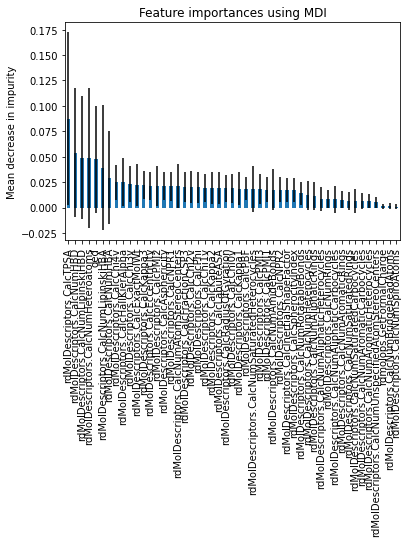

In [12]:
import time
import numpy as np
from matplotlib import pyplot as plt

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

import pandas as pd

idcs = np.argsort(-importances)

forest_importances = pd.Series(importances[idcs], index=feature_names[idcs])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[idcs], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [13]:
import json
with open('descending_importance.json', 'w') as f:
    json.dump({name: imp for name, imp in zip(feature_names[idcs], importances[idcs])}, f)